# Computing a Convex Hull

A few months ago, I was taken with the strange desire to compute the area enclosed by a group of random points.  This is called the "convex hull."  Imagine a game of darts, in which you throw some number n of darts at a board.  Then imagine placing a rubber band around all those darts, and computing the area the rubber band. I was interested in computing the area within that rubber band. !["Rubber Banding" a goup of points](ConvexHull.svg)  The result was roughly a hundred lines of Python code that was a lot of fun to write, that didn't do anything useful, but that let me think through some interesting problems about randomness and about optimization.

The first part of the problem is relatively trivial.  We're going to need to compute the area of a polygon formed by a lot of points.  We start with a pair of functions that make it easier refer to a point's x and y coordinates.  We'll use these functions heavily throughout this project:

In [3]:
x = lambda p: p[0]  # for accessing x and y coordinates without going crazy
y = lambda p: p[1]
x( (1.3, 2.4) ) # just to prove that this works

1.3

To compute the area of an arbitrary polygon, simply multiplying the width and the height won't do.  Fortunately, it's easy to look [this calculation](http://www.mathopenref.com/coordpolygonarea.html) up, and implement it in Python.  

In [4]:
def poly_area(poly):
    """ area of a polygon.  poly is a list of (x,y) tuples. Implements formula from
        http://www.mathopenref.com/coordpolygonarea.html (p. 353 CRC math, 18th ed) 
        The polygon doesn't have to be convex."""
    poly += [poly[0]] # append to end to make circular
    area = 0
    for i in range(0, len(poly)-1):
        area += (x(poly[i])*y(poly[i+1]) - y(poly[i])*x(poly[i+1]))/2
    return abs(area)

poly_area( [(0,0), (0,1), (1,1), (1,0)] )  # test this with a unit square

1.0

Computing the area of a polygon is nice, but we don't yet have any points. So let's get some.  Here's a simple method that returns a list of random points on the unit square.  Each point is an (x,y) tuple:

In [5]:
import random
def random_points(n):
    throws = []
    for i in range(0,n):
        throws.append((random.uniform(0,1), random.uniform(0,1)))
    return throws

poly_area(random_points(3)) # just to test. Output meaningless, but shouldn't be 0 or > 1

0.06423453553921131

I've chosen a uniform distribution on the unit square; but nothing about this problem says that we need a unit square or a uniform distribution.  I haven't experimented with other distributions, but that would be fun. If you want to see how it works, go for it.  [Python's `random` library](https://docs.python.org/3/library/random.html) implements many distributions.  For example, `gauss(0,1)` gives you a Gaussian (bell curve) distribution with a standard deviation of 1.  Try it. 

We now have a list of random points.  But we don't yet have a polygon; if you trace the path out, it will have all sorts of crossings that make it impossible to compute the area, let alone the convex hull.  So for the next step, let's reorder our points into a "clockwise" list.  Once we have a list of points in clockwise order, we have something we can call a polygon, and we can start working.

What's the best way to make a clockwise list? Here's the approach I took. First, find the leftmost and rightmost points in the graph.  We can do that by sorting in order of increasing x.  Then draw a line from the leftmost point to the rightmost point.  The points above that line in order of increasing x, form the part of the path that moves from left to right.  The points below that line, in order of decreasing x, are the part of the path that moves from the rightmost point back to the origin.  So it's just a matter of rearranging the points. 

How do we implement this?  Let's start by defining a function that returns a function representing the line between two points.  We'll need this later in the program, anyway.  It's basically just a matter of computing the slope of the line (delta y / delta x), implementing the point-slope form of the line that you should remember from middle school, and returning that as a lambda function:

In [6]:
def make_line(p1, p2):
    """ return the function for the line between p1 and p2 """
    m = (y(p2) - y(p1))/(x(p2)-x(p1))
    return lambda t : m*(t - x(p1)) + y(p1)

make_line( (0,0), (1,1) )(1.5) # test this: make the line between (0,0) and (1,1), evaluate it at x = 1.5

1.5

The test returns a function for the line between the points (0,0) and (1,1), and evaluates that function at x = 1.5.  

Now for taking our list of random points and making a clockwise path.  We start by sorting the points in order of increasing x.  That makes it easy to pick out the leftmost point (the first) and the rightmost (the last).  It also makes it easier to reassemble the points.  

Then we build two more lists: points that are above the line are on the "outgoing" path (the left to right progression on the "top side" of the polygon); points below the line are on the "incoming" path (the right to left progression on the "bottom side" of the polygon).  Since we sorted by x, our points are already in order, more-or-less: we can use the "top" points-is, and all we have to do is reverse the order of the "bottom" points, so they're now in order of decreasing x.  Then we reassemble the list.

In [7]:
def make_clockwise(points):
    """ make a clockwise path between a list of arbitrary points 
        points sorted by x.  """
    points.sort(key = x)
    aboves = []
    belows = []
    medianline = make_line(points[0], points[-1])
    for i in range(1, len(points) -1): # 1 & -1 bc no first/last point
        if y(points[i]) > medianline(x(points[i])): # above
            aboves += [points[i]]
        else:  # below
            belows += [points[i]]
    belows.reverse()
    clockwise_points = [points[0]] + aboves + [points[-1]] + belows
    return clockwise_points

poly_area(make_clockwise(random_points(1000)))

0.4951061280320711

- comment- I haven't tried to prove this, but it seems intuitively right that, as the number of points goes to infinity, the area of the polygon goes to 0.5.  The outermost points are all on the edges of the unit square, but the boundary is zigzagging in and out.

Now we're done with the preparatory work.  Time to find the convex hull.  We'll work through the list of points, looking at each point and determining whether it's in the interior or on the hull.  We throw out the points on the interior.  We may have to do this multiple passes through the list, because the shape of the polygon is changing as we discard the interior points.  So we work through the list repeatedly until nothing changes: then we're done.

How do we decide whether a point is in the interior?  The leftmost and rightmost points on the polygon will never be deleted; they're always on the exterior. (Think a minute to convince yourself that this is true.)  We always know where the leftmost point is: it's the first element in the list.  The rightmost point is a problem, though.  While our list is sorted, it's sorted in a special way: the points are in counterclockwise order.  Therefore, as we delete elements, the index of the rightmost point moves around: we can't count on it being the last element, or any given element.  So we need a utility function to find the rightmost point.  

- comment-Or we could do some bookkeeping to keep track of the rightmost point. Somewhat faster but brain-twisting
- comment-Might have been a good idea to keep the above and below lists separate. 

So, let's start with a utility to find the rightmost point (maximum x coordinate) in a polygon: 

In [8]:
def max_x_index(points):
    """ find max x of a polygon, in counterclockwise order """
    i = 0
    while x(points[i]) < x(points[i+1]) : i += 1
    return i

max_x_index(make_clockwise(random_points(1000)))

381

Now, let's work through the points.  We can test whether any point is in the interior by comparing it to its neighbors.  If a point is in the upper part of the polygon (that is, if it comes before the right-most point in the list), it's in the interior if it's below the line drawn between its neighbors.  Likewise, a point in the lower part of the polygon is in the interior if it's above the line drawn between its neighbors.  Point A is above the center line, but below the line between its two neighbors.  Likewise, point B is below the center line, but above the line between its two neighbors.  Therefore, to form the hull, we discard both of these points. ![Removing interior points](pointremoval.svg) 
The function `below_above()` handles all of this logic.  We use `make_line()` to construct the line between two points.  Then it's simple to take the x coordinate of the point we're testing, compute the y coordinate on the line between the two points, and determine whether our target point is above or below the line.  The direction parameter chooses which test to use; it is negative for points in the upper part of the polygon, positive for points in the lower part.  (If point i is in the upper part, its index must be less than the index of the rightmost point, so i - mxi is negative.)  If `below_above()` returns True, the point is on the interior, so we discard it.  

- comment- the logic in below_above() minimizes the amount of code, but is unnecessarily confusing. Minimizing code isn't always a good idea.  I could rewrite it with separate functions for the outgoing and returning parts of the polygon, which is how the code worked a long time ago.  Might be better to leave that as an exercise. 

In [9]:
def isInterior(p, p1, p2, direction):
    """ return true if point is above or below segment, according to dir 
        (<0 means below, >0 means above) ; return True means delete (interior point) """
    seg = make_line(p1,p2)
    iy = seg(x(p))
    if direction < 0 : return iy > y(p) 
    elif direction > 0 : return iy < y(p)
    else : return False  # for direction == 0, which only happens on rightmost point

isInterior( (0,0), (1,1), (.5, .25), -1) # .5, .25 is below the line between 0,0 and 1,1, so False

False

Finally, we get to the code that processes all the points.  Rather than discarding exterior points, we build a new list (nextcp) with points that we believe are on the exterior; then, when we've worked through the entire list, we swap the new list (nextcp) for the old one.  It turns out that's much more efficient; I'll discuss why later.  

It might seem like one pass through the loop will do the trick.  That's not true. I keep a flag, unchanged, that we set to False whenever we find an interior element that must be eliminated from the result.  When we go through the entire list without finding any interior points, we're done. 

- comment - I spent some time trying to eliminate the need for multiple passes.  I eventually decided it couldn't be done.  Can you see why?  To do so, you'll want to write code that displays the initial polygon, and the polygon after the first pass.  (One pass is enough to understand the problem.) 

- question- the program I wrote includes some machinery for graphing the polygon, or graphing performance.  Graphing performance will burn HOURS of CPU time if anyone decides to do something interesting.  (A million points takes a few seconds, but do you want to do a plot that shows this is really nlog(n)?)

In [21]:
def make_convex(poly):
    """ make the polygon convex by eliminating interior points 
        basic idea: for each point, if point is in the exterior (relative
        to its neighbors), add it to the next polygon.  Cycle until you 
        go through the whole poly w/o tossing anything.  n*log(n) """
    cp = poly[:] + [poly[0]] # make a complete loop
    unchanged = False
    while unchanged is False: # loop until no changes...
        unchanged = True
        i = 1
        nextcp = [cp[0]]
        mxi = max_x_index(cp)
        for i in range(1, len(cp)-1):
            if isInterior(cp[i], cp[i-1], cp[i+1], i - mxi) : 
                unchanged = False # comment this out, replace with pass for one trip only
            else: 
                nextcp.append(cp[i])
        cp = nextcp 
        cp.append(cp[0]) # need to keep this path closed
    cp.pop()  # last el = 1st, no longer need closed path, so don't want it
    return cp

poly_area(make_convex(make_clockwise(random_points(10))))

0.48683743633360316

A number?  All that work and we just get a number?  OK, I was only planning to compute an area.  But with all these polygons, it would be nice to see the starting result and the dn.  So this time with graphics:

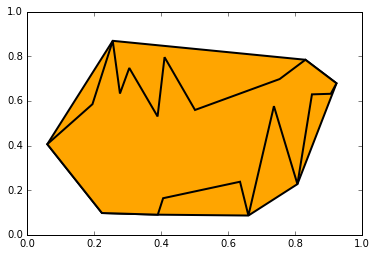

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches

def get_plot_path(points):
    """ mostly copied from http://matplotlib.org/users/path_tutorial.html
        actual display in do_plots. Not clear that codes is needed. """
    points += [points[0]] # close the loop
    codes = []
    codes += [Path.MOVETO]
    for i in range(1,len(points)-1): 
        codes += [Path.LINETO]
    codes += [Path.CLOSEPOLY]
    path = Path(points, codes)
    return path

p1 = make_clockwise(random_points(20))
p2 = make_convex(p1)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
for path in [get_plot_path(p2), get_plot_path(p1)]:
    patch = patches.PathPatch(path, facecolor='orange', lw=2)
    ax.add_patch(patch)
plt.show()


The "inner," more jagged path is the original set of random points, converted into a counterclockwise polygon.  The outerpath is the convex hull.  If you want to get a feel for how the algorithm works, try modifying make_convex.  Change the line that reads `unchanged = False` to read `pass`, then re-run the code.  With this modification, make_convex() will only make one pass through the points.  You should be able to look at the result and understand which points were eliminated, which were kept, and why.  

And that's pretty much it. Writing the code is arguably less interesting than thinking about what it means.  First, how quickly does the convex hull grow as the number of points increases? Quite slowly.  A convex hull of a million random points is usually only 25 or 30 points.  That makes sense: most of the points are in the interior of the bounding polygon. Would we see the same slow growth with a Gaussian distribution?  I haven't tried it, but I bet we would.  (Don't do this on O'Reilly's server, but feel free to download the notebook and try it on your laptop.)

Second, how fast is this code?  Reasonably fast on a laptop: finding the hull of a million points takes roughly 10 seconds.  But what's more important than speed is how the time grows as the number of points increases.  As I've presented it, the time grows as N log(N).  Here's a hand-waving argument for why: We have to process each point, and decide whether it's in the interior or exterior.  That's N, where N is the number of points.  And the number of times we go through the loop appears to (massive handwaving) increase as the log of N. 

But that wasn't my first version, which increased as N^2 log(N). And that's important.  The first version implemented the algorithm exactly as I described it: when we found a point in the interior, that point was deleted from the polygon.  So there were a lot of calls to Python's `del()` function.  `del()` is a rather odd animal that I won't go into, but regardless of how you delete points from a list, you'll come up against an immovable obstacle.  The time it takes to delete a point from a list is proportional to the length of the list.  So, if we have N points, and we're going to delete almost all of them, the time it takes will be proportional to N squared.  And we still have to take into account the log(n) factor, because the first trip through the polygon doesn't find all the interior points.

Let's defer the final solution for a moment.  My second (not so good) solution was fairly interesting, and might be useful for some other problems.  I observed that finding the hull of a million points took a long time, but finding the hull of 1000 points was very quick.  And the hull of a thousand points only had 10 or 15 points in it.  So I tried finding the hull 1000 points at a time: do the first 1000 points, end up with 15 points, add the next 1000 points, end up with 15 points again, and so on.  That actually worked quite well: it's almost competitive with the final N log(N) algorithm, for a million points or so.  The time still grows as N^2 log(N), so it's a disaster for really huge problems, like 100 million points.  But it was surprisingly good for a million points or so, and it's an idea I'll keep around; I may eventually find a problem where it's useful.  

- comment - optimal grouping, if anyone cared, turns out to be about 2500 points.  Doesn't appear to depend on the size of the problem.  Probably depends strongly on the characteristics of your computer.

The final solution came about as an anticlimax.  I broke down and looked up [Convex Hull on Wikipedia](https://en.wikipedia.org/wiki/Convex_hull), which told me that the algorithm can be implemented in N log(N) time.  I knew I hadn't gotten there, but after a little thought, I said "Oh. Rather than deleting elements from the interior, build a new list from elements on the exterior:  appending to a list is really fast."  Problem solved.

- question - Is it worth presenting this material?  Can it done in a better way than just writing about it?  I really don't want to go back to that old code. 

## Exploring Further

This program wasn't an attempt to write production code: it was an experiment in problem solving, in optimization, and in seeing what would work.  With that in mind, here are a few ideas that you might want to experiment with.

### Arrays?

Throughout this program, I've used Python lists.  The numpy library includes support for arrays, and I suspect arrays would be significantly faster.  Try rewriting the program to use arrays.  Here's a not-very-helpful start:

In [11]:
import numpy 

Think about two things as you try to solve this problem.  First, arrays need to know their size when they're created.  They're not like lists, where you can start with [] and append to your hearts' content.  You can append to arrays after they have been created, but that's inefficient, no better than using lists.

### Getting rid of the outer loop?

make_convex() has an outer `while` loop surrounding the loop that actually inspects and saves the interior points.  Every pass through the list will eliminate roughly 90% of the interior points, but not all of them; you have to keep working through the list until you've eliminated everything on the interior.  It's a useful exercise to add some code to plot the first few polygons you get from this process.  Work through the algorithm in your head until you understand why that outer loop is necessary.  

Once you've done that, here's the big question: is it possible to rewrite make_convex() to eliminate that outer loop?  And if you do so, will it be any faster than my version?  

- comment - my answer: It's possible to rewrite make_convex() without the outer loop, so that you only visit each point once.  There's a cost: you will need to introduce an even deeper loop: you'll end up with a nested loop either way.  Will it be faster?  I don't think it will be; I gave up when I convinced myself that eliminating the outer loop, so you only made one pass through the list of points, wouldn't save much, would add a lot of complexity, and would at best be marginally faster.

- more comment - lesson in optimizing the wrong thing: I was trying to get rid of a log(n) when there was an n^2 staring me in the face (changing from deleting interior points to saving exterior points).  Don't do that.  

### How DRY are you?

You've probably heard of the DRY principle, which comes from Dave Thomas' Pragmatic Programmer.  DRY stands for "Don't Repeat Yourself", and it's a good idea.  If you find yourself cutting and pasting code, you're probably doing something wrong.  At best, you're creating code that's hard to maintain: if you find a bug in the cut-paste section, you have to fix it everywhere you pasted it. 

Instead of a single isInterior() function, the first version of this program had two functions: isAbove() and isBelow().  They figured out whether a point was above or below the line passing through two other points.  As you can imagine, these functions were fairly similar, and were a good example of cut-paste code.  The only difference might have been between < and > in one if statement.  So, thinking of the DRY principle, and my own experience that cut-paste programming leads to misery, I combined isAbove() and isBelow() into a single isInterior().

Try going the other way: replace isInterior() with isAbove() and isBelow().  Of course, this will require some changes to the logic in makeConvex().  Then answer the question: what version of the program do you like better?   There's no right answer.   

- comment - Don't assume that the DRY version is better; I think it's more complex and much harder to understand.  